In [ ]:
%pip install pyalgotrade
%pip install pandas

In [150]:
import numpy as np
import pandas as pd

from pyalgotrade import strategy, barfeed, bar, plotter
from pyalgotrade.bar import Frequency
from pyalgotrade.technical import ma, bollinger
from pyalgotrade.stratanalyzer import returns, sharpe, drawdown, trades

In [ ]:
df = pd.read_csv("NIFTY50.csv")

cols = df.columns[1:] 
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df['Volume'] = np.iinfo(np.int32).max  

In [ ]:
# Example BarFeed for dataframes with data for a single instrument.
class DataFrameBarFeed(barfeed.BaseBarFeed):
    def __init__(self, dataframe, instrument, frequency):
        super(DataFrameBarFeed, self).__init__(frequency)
        self.registerInstrument(instrument)
        self.__df = dataframe
        self.__instrument = instrument
        self.__next = 0

    def reset(self):
        super(DataFrameBarFeed, self).reset()
        self.__next = 0

    def peekDateTime(self):
        return self.getCurrentDateTime()

    def getCurrentDateTime(self):
        ret = None
        if not self.eof():
            rowkey = self.__df.index[self.__next]
            ret = df.iloc[rowkey]["Date"]
        return ret

    def barsHaveAdjClose(self):
        return False

    def getNextBars(self):
        ret = None
        if not self.eof():
            # Convert the dataframe row into a bar.BasicBar
            rowkey = self.__df.index[self.__next]
            row = self.__df.iloc[rowkey]
            bar_dict = {
                self.__instrument: bar.BasicBar(
                    row["Date"],
                    row["Open"],
                    row["High"],
                    row["Low"],
                    row["Close"],
                    row["Volume"],
                    None,  # row["Adj Close"],
                    self.getFrequency(),
                )
            }

            ret = bar.Bars(bar_dict)
            self.__next += 1
        return ret

    def eof(self):
        return self.__next >= len(self.__df.index)

    def start(self):
        pass

    def stop(self):
        pass

    def join(self):
        pass


: 

In [ ]:
class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, capital):
        super(MyStrategy, self).__init__(feed, capital)
        self.__instrument = instrument
        self.__position = None
        self.__sma = ma.SMA(feed[instrument].getCloseDataSeries(), 15)

    @staticmethod
    def safe_round(value, digits):
        if value is not None:
            value = round(value, digits)
        return value

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info("BUY at \u20B9 %.2f" % (execInfo.getPrice()))

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info("SELL at \u20B9 %.2f" % (execInfo.getPrice()))
        self.__position = None

    def onExitCanceled(self, position):
        self.__position.exitMarket()

    def onBars(self, bars):
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:
                self.__position = self.enterLong(self.__instrument, 10, True)
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
            self.__position.exitMarket()


capital = 100000
feed = DataFrameBarFeed(df, "nifty", Frequency.DAY)
myStrategy = MyStrategy(feed, "nifty", capital)

returnsAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(returnsAnalyzer)

plt = plotter.StrategyPlotter(myStrategy)

plt.getOrCreateSubplot("returns").addDataSeries("Simple returns", returnsAnalyzer.getReturns())


myStrategy.run()
myStrategy.info("Final portfolio value: $%.2f" % myStrategy.getResult())

# Plot the strategy.
plt.plot()

2013-03-05 00:00:00 broker.backtesting [DEBUG] Not enough cash to fill nifty order [7] for 17 share/s
2013-08-21 00:00:00 broker.backtesting [DEBUG] Not enough cash to fill nifty order [25] for 19 share/s


Final portfolio value: Rs.107949.70
Cumulative returns: 7.95 %
Sharpe ratio: -0.54
Max. drawdown: 31.88 %
Longest drawdown duration: 2010 days


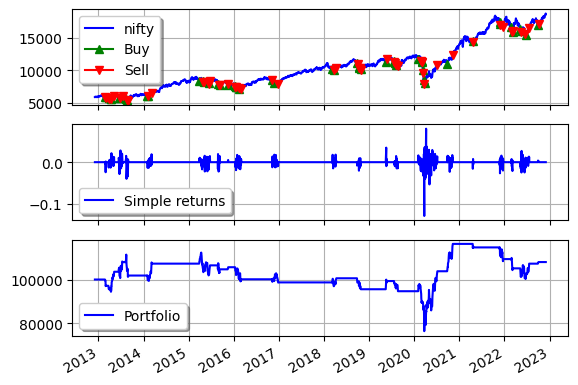

In [160]:
class BBands(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, bBandsPeriod, capital):
        super(BBands, self).__init__(feed, capital)
        self.__instrument = instrument
        self.__bbands = bollinger.BollingerBands(
            feed[instrument].getCloseDataSeries(), bBandsPeriod, 1.5
        )
        self.__position = None
        self.__SL = None
        self.__TL = None
        self.RR_ratio = 5

    def getBollingerBands(self):
        return self.__bbands

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onFinish(self, bars):
        if self.__position is not None:
            self.info("Getting rid")
            self.__position.exitMarket()

    def onBars(self, bars):
        lower = self.__bbands.getLowerBand()[-1]
        upper = self.__bbands.getUpperBand()[-1]
        if lower is None:
            return

        bar = bars[self.__instrument]

        if self.__position is None:
            if bar.getHigh() < lower:
                buy_price = bar.getHigh()
                sharesToBuy = int(self.getBroker().getCash(False) / buy_price)
                # self.info("Placing Buy Stop order")
                self.__position = self.enterLongStop(
                    self.__instrument, buy_price, sharesToBuy
                )
                self.__SL = bar.getLow()
                self.__TL = buy_price + (buy_price - bar.getLow()) * self.RR_ratio

        elif self.__position.isOpen() and (
            bar.getLow() <= self.__SL or bar.getHigh() >= self.__TL
        ):
            # self.info("Placing Sell Market order")
            self.__position.exitMarket(goodTillCanceled=None)


instrument = "nifty"
bBandsPeriod = 40
capital = 100000
feed = DataFrameBarFeed(df, instrument, Frequency.DAY)
myStrategy = BBands(feed, instrument, bBandsPeriod, capital)

# Attach different analyzers to a strategy before executing it.
retAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(retAnalyzer)
sharpeRatioAnalyzer = sharpe.SharpeRatio()
myStrategy.attachAnalyzer(sharpeRatioAnalyzer)
drawDownAnalyzer = drawdown.DrawDown()
myStrategy.attachAnalyzer(drawDownAnalyzer)
tradesAnalyzer = trades.Trades()
myStrategy.attachAnalyzer(tradesAnalyzer)


plt = plotter.StrategyPlotter(myStrategy)
plt.getOrCreateSubplot("returns").addDataSeries(
    "Simple returns", retAnalyzer.getReturns()
)

## PARAMS
# Fitness (>1)
# Sharpe (>1.25)
# Returns
# Turnover (>1% and <70%)
# DrawDown
# Margin

myStrategy.run()
print("Final portfolio value: Rs.%.2f" % myStrategy.getResult())
print("Cumulative returns: %.2f %%" % (retAnalyzer.getCumulativeReturns()[-1] * 100))
print("Sharpe ratio: %.2f" % (sharpeRatioAnalyzer.getSharpeRatio(0.065)))
print("Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print("Longest drawdown duration: %d days" % drawDownAnalyzer.getLongestDrawDownDuration().days)

# Plot the strategy.
plt.plot()
